# **Introduction to the problem**



This problem focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.

The complexity of the dataset is limited to 20 classes: tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle

Kaggle's link [here](https://www.kaggle.com/bulentsiyah/semantic-drone-dataset).

# **Preliminary operations**

In this section we prepare the necessary material for this project.

First of all we install the package dedicated to kaggle to download the dataset.

In [ ]:
! pip install -q kaggle

Then we need to load our Kaggle's API

In [ ]:
from google.colab import files

files.upload()

The below code removes any file and delete .kaggle directory, move the uploaded token to a newly created directory.

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download Dataset from Kaggle using Kaggle's API and unzip.

In [ ]:
! kaggle datasets download -d bulentsiyah/semantic-drone-dataset

!unzip ./data/semantic-drone-dataset.zip

!rm ./data/semantic-drone-dataset.zip

# **Import base libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import glob
import os
import sklearn
import seaborn as sns
import GPUtil

from tensorflow import keras
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from albumentations import  HorizontalFlip, VerticalFlip
from tqdm import tqdm

# **Utility functions**

Functions for load images and respective masks.

In [2]:
HEIGHT = 320
WIDTH = 480

def get_file_name(file_path):
    return os.path.basename(file_path)

def get_file_paths(folder_path, search_pattern, search_in_subfolders=False):
    if (search_in_subfolders):
        pathname = folder_path+'/**/'+search_pattern
    else:
        pathname = folder_path+'/'+search_pattern

    file_paths = glob.glob(pathname,recursive=search_in_subfolders)

    return [path.replace('\\','/') for path in file_paths]

def normalize_image(image):
    image = image / 255.0
    image = image.astype(np.float32)
    
    return image

def normalize_mask(mask):
    mask = mask.astype(np.int32)
    
    return mask

def load_image_dataset_with_masks(image_folder_path, mask_folder_path, 
                                  image_search_pattern, image_count = None):
    image_file_path_list = get_file_paths(image_folder_path, image_search_pattern)

    images = []
    masks = []

    for image_file_path in image_file_path_list:
        if (image_count!= None and len(images) == image_count):
          break
        
        # Image read
        image = cv2.imread(image_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Image resize
        image = cv2.resize(image, (WIDTH, HEIGHT)) 
        
        # Image normalization
        image = normalize_image(image) 
        
        # Mask read
        mask = cv2.imread(mask_folder_path + '/' + get_file_name(image_file_path).replace("jpg", "png"), cv2.IMREAD_GRAYSCALE)
        
        # Mask resize
        mask = cv2.resize(mask, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # Mask normalization
        mask = normalize_mask(mask)
        
        images.append(image)
        masks.append(mask)

    return np.array(images),np.array(masks)

# **Training Dataset** 

In this project the dataset contains 400 images and 400 respective masks (ground truth).

The number of classes is 23 (some classes includes different elements).

Below code contains the code to show a random image and respective mask.

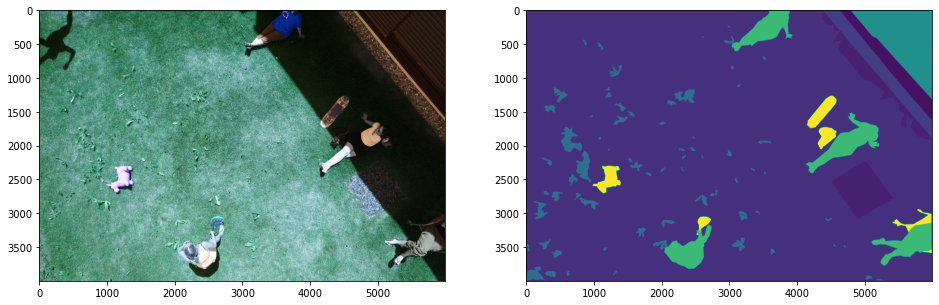

In [3]:
dataset_path = 'data/dataset/semantic_drone_dataset'
images_path = dataset_path + '/original_images'
masks_path = dataset_path + '/label_images_semantic'

random_image = random.choice(os.listdir(images_path))
random_mask = random_image.replace("jpg", "png")

# Show a random image
_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(cv2.imread(images_path + "/" + random_image, cv2.COLOR_BGR2RGB));
axs[1].imshow(cv2.imread(masks_path + "/" + random_mask, cv2.IMREAD_GRAYSCALE));

Let's see the classes of the problem from the csv.

In [4]:
classes = pd.read_csv("data/class_dict_seg.csv")
classes

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

Get the number of classes from csv.

We remove conflicting class from the count because there are no pixels of this class.

In [5]:
number_of_classes = classes.loc[classes['name'] != "conflicting"].shape[0]

The original images have a size of 6000 x 4000, this leads a huge amount of ram memory when loaded. For this reason when the images are loaded we resize them to WIDTH x HEIGHT to reduce size but at the same time mantaining aspect ratio.

In [6]:
# Loading images and mask
print('Loading images and masks...')
images, masks = load_image_dataset_with_masks(images_path, masks_path, '*')

print('Images shape: ', images.shape)
print('Masks shape: ', masks.shape)

Loading images and masks...
Images shape:  (400, 320, 480, 3)
Masks shape:  (400, 320, 480)


# **Preprocessing** 

In the cell below we transorm the masks into a flat array. It is useful for some operations.

In [7]:
masks_flatten = masks.flatten()

Below code shows a random image and respective mask resized.

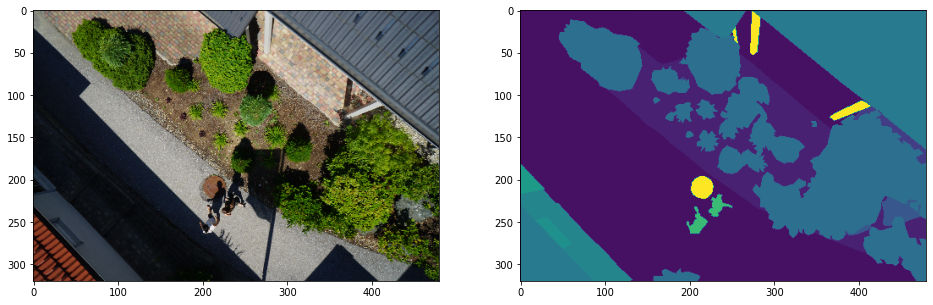

In [8]:
idx = random.randint(0, len(images))

_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(images[idx]);
axs[1].imshow(masks[idx]);

In the cell below we define a function that count the number of pixel of each class over the total of pixel.

In [9]:
def count_pixel_per_class(masks, n_classes=number_of_classes):
    total_pixel = len(masks)
    for i in range (0, n_classes):
        print("Percentage class {} over total of pixel: {:.5f}%".format(i, sum(masks == i) / total_pixel))

In [22]:
count_pixel_per_class(masks_flatten)

Percentage class 0 over total of pixel: 0.00394%
Percentage class 1 over total of pixel: 0.37672%
Percentage class 2 over total of pixel: 0.03194%
Percentage class 3 over total of pixel: 0.19951%
Percentage class 4 over total of pixel: 0.07292%
Percentage class 5 over total of pixel: 0.02210%
Percentage class 6 over total of pixel: 0.00718%
Percentage class 7 over total of pixel: 0.00638%
Percentage class 8 over total of pixel: 0.07091%
Percentage class 9 over total of pixel: 0.07350%
Percentage class 10 over total of pixel: 0.02683%
Percentage class 11 over total of pixel: 0.00559%
Percentage class 12 over total of pixel: 0.00031%
Percentage class 13 over total of pixel: 0.00955%
Percentage class 14 over total of pixel: 0.00053%
Percentage class 15 over total of pixel: 0.01051%
Percentage class 16 over total of pixel: 0.00014%
Percentage class 17 over total of pixel: 0.00785%
Percentage class 18 over total of pixel: 0.00216%
Percentage class 19 over total of pixel: 0.02049%
Percentage

We observed that this problem is not balanced for this reason we compute the weight for each class.

In [9]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(masks), y = masks_flatten)
class_weights = dict(enumerate(class_weights))

Then we transform masks to categorical based on number of classes. This is useful in the next steps when we train the model.

In [10]:
masks = to_categorical(masks, number_of_classes)

Now the dataset is loaded so we can split it into training set, validation set and test set.

We split the dataset into 200 images for training set, 100 for validation set and last 100 for test set.

We use a random seed for reproducibility.

In [11]:
random_seed=42 
validation_size=100

train_x, validation_x, train_y, validation_y = train_test_split(images, masks,                                              
                                                                test_size=validation_size,
                                                                random_state=random_seed)

# Split on train_x and train_y 
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y,                                              
                                                    test_size=validation_size,
                                                    random_state=random_seed)

In [12]:
print('Training set X shape:', train_x.shape)
print('Validation set X shape:', validation_x.shape)
print('Test set X shape:', test_x.shape)

print('\nTraining set Y shape:', train_y.shape)
print('Validation set Y shape:', validation_y.shape)
print('Test set Y shape:', test_y.shape)

Training set X shape: (200, 320, 480, 3)
Validation set X shape: (100, 320, 480, 3)
Test set X shape: (100, 320, 480, 3)

Training set Y shape: (200, 320, 480, 23)
Validation set Y shape: (100, 320, 480, 23)
Test set Y shape: (100, 320, 480, 23)


In these cells below we see how *train_test_and_split* distributes the class among sets.

In [20]:
count_pixel_per_class(np.argmax(train_y, axis=-1).flatten())

Percentage class 0 over total of pixel: 0.00380%
Percentage class 1 over total of pixel: 0.38692%
Percentage class 2 over total of pixel: 0.03062%
Percentage class 3 over total of pixel: 0.18744%
Percentage class 4 over total of pixel: 0.07126%
Percentage class 5 over total of pixel: 0.02083%
Percentage class 6 over total of pixel: 0.00776%
Percentage class 7 over total of pixel: 0.00675%
Percentage class 8 over total of pixel: 0.07096%
Percentage class 9 over total of pixel: 0.07046%
Percentage class 10 over total of pixel: 0.02890%
Percentage class 11 over total of pixel: 0.00652%
Percentage class 12 over total of pixel: 0.00024%
Percentage class 13 over total of pixel: 0.00942%
Percentage class 14 over total of pixel: 0.00057%
Percentage class 15 over total of pixel: 0.01057%
Percentage class 16 over total of pixel: 0.00012%
Percentage class 17 over total of pixel: 0.00882%
Percentage class 18 over total of pixel: 0.00225%
Percentage class 19 over total of pixel: 0.02282%
Percentage

In [21]:
count_pixel_per_class(np.argmax(validation_y, axis=-1).flatten())

Percentage class 0 over total of pixel: 0.00408%
Percentage class 1 over total of pixel: 0.37242%
Percentage class 2 over total of pixel: 0.03125%
Percentage class 3 over total of pixel: 0.21205%
Percentage class 4 over total of pixel: 0.07375%
Percentage class 5 over total of pixel: 0.01980%
Percentage class 6 over total of pixel: 0.00605%
Percentage class 7 over total of pixel: 0.00626%
Percentage class 8 over total of pixel: 0.07411%
Percentage class 9 over total of pixel: 0.06739%
Percentage class 10 over total of pixel: 0.02766%
Percentage class 11 over total of pixel: 0.00486%
Percentage class 12 over total of pixel: 0.00040%
Percentage class 13 over total of pixel: 0.00828%
Percentage class 14 over total of pixel: 0.00058%
Percentage class 15 over total of pixel: 0.00999%
Percentage class 16 over total of pixel: 0.00016%
Percentage class 17 over total of pixel: 0.00654%
Percentage class 18 over total of pixel: 0.00268%
Percentage class 19 over total of pixel: 0.01783%
Percentage

In [19]:
count_pixel_per_class(np.argmax(test_y, axis=-1).flatten())

Percentage class 0 over total of pixel: 0.00408%
Percentage class 1 over total of pixel: 0.36062%
Percentage class 2 over total of pixel: 0.03529%
Percentage class 3 over total of pixel: 0.21109%
Percentage class 4 over total of pixel: 0.07539%
Percentage class 5 over total of pixel: 0.02694%
Percentage class 6 over total of pixel: 0.00716%
Percentage class 7 over total of pixel: 0.00576%
Percentage class 8 over total of pixel: 0.06759%
Percentage class 9 over total of pixel: 0.08567%
Percentage class 10 over total of pixel: 0.02188%
Percentage class 11 over total of pixel: 0.00444%
Percentage class 12 over total of pixel: 0.00037%
Percentage class 13 over total of pixel: 0.01110%
Percentage class 14 over total of pixel: 0.00040%
Percentage class 15 over total of pixel: 0.01088%
Percentage class 16 over total of pixel: 0.00016%
Percentage class 17 over total of pixel: 0.00722%
Percentage class 18 over total of pixel: 0.00145%
Percentage class 19 over total of pixel: 0.01849%
Percentage

# **Jaccard index**

Beyond accuracy for this type of problem we use **Jaccard Index** (or intersection over union) to measure the performances.

\begin{align*}
J(A,B)=\frac{|A\cap B|}{|A \cup B|}
\end{align*}

In [13]:
smooth = 1e-12

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

# **Models**

## **U-Net**


The U-Net model is a **fully convolutional neural network** originally proposed to perform binary segmentation (foreground and background) of medical images. It is essentially made up of three parts:
1. **Downsampling Path** - composed of 4 blocks, has the purpose of reducing the spatial dimensions of the input while increasing its depth. Each block consists of two convolution layers (3x3 filter, stride = 1, no padding and ReLU as activation function) and one max-pooling level (2x2, stride = 2 and no padding).
2. **Bottleneck** - composed of two convolutional layers (3x3 filter, stride = 1, no padding and ReLU as activation function).
3. **Upsampling Path** - composed of 4 blocks, it aims to bring the segmentation map returned by the Bottleneck to the spatial dimensions of the input image. Each block consists of a upsampling level to double the spatial dimensions, a convolution level (2x2 filter, stride = 1, no padding) that halves the number of channels, concatenation (skip connections) with the corresponding feature map of the Downsampling Path and finally two layers of convolution (filter 3x3, stride = 1, no padding and ReLU as activation function).

The final level of convolution (filter 1x1, stride = 1, no padding and Sigmoid as the activation function) is used to return a segmentation map with a depth equal to the number of problem classes. 


![alt text](https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/raw/53b5e697d3c010546b9443534a067541c4c50eb9/images/u-net-architecture.png)

### **Downsampling block**
The following cell defines the **down_block (...)** function to create a block of *downsampling* input data:
- the feature map (*x*);
- the number of filters (*filter_count*).

In [14]:
def down_block(x, filter_count):
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(x)
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    p = keras.layers.MaxPool2D(2, 2)(c)
    return c, p

### **Bottleneck**
The following cell defines the **bottleneck (...)** function to create the *bottleneck* input data:
- the feature map (*x*);
- the number of filters (*filter_count*).



In [15]:
def bottleneck(x, filter_count):
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(x) 
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    return c

### **Upsampling block**
The following cell defines the **up_block (...)** function to create an *upsampling* data input block:
- the feature map (*x*);
- the *skip connection* to concatenate (*skip*);
- the number of filters (*filter_count*).

In [16]:
def up_block(x, skip, filter_count):
    us = keras.layers.UpSampling2D(2)(x)
    c = keras.layers.Conv2D(filter_count, 2, padding='same')(us)
    concat = keras.layers.Concatenate()([c, skip])
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(concat)
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    return c

### **Model definition**

The below code defines **U-Net** network with following parameters:

*   **image_shape**: input of images.
*   **block_filter_count**: number of filters to use in each downsampling and upsampling block.
*   **n_classes**: number of classes of the problem.

In [17]:
def UNet(image_shape, block_filter_count, n_classes = number_of_classes):
        
    inputs = keras.layers.Input(image_shape)
        
    # Downsampling path
    p0 = inputs
    c1, p1 = down_block(p0, block_filter_count[0]) 
    c2, p2 = down_block(p1, block_filter_count[1]) 
    c3, p3 = down_block(p2, block_filter_count[2]) 
    c4, p4 = down_block(p3, block_filter_count[3]) 
    
    # Bottleneck
    bn = bottleneck(p4, block_filter_count[4])
    
    # Upsampling path
    u1 = up_block(bn, c4, block_filter_count[3]) 
    u2 = up_block(u1, c3, block_filter_count[2]) 
    u3 = up_block(u2, c2, block_filter_count[1]) 
    u4 = up_block(u3, c1, block_filter_count[0]) 
    
    # Output
    outputs = keras.layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(u4)
    
    # Reshape
    # outputs_reshaped = keras.layers.Reshape((image_shape[0] * image_shape[1], number_of_classes))(outputs) 

    return keras.models.Model(inputs, outputs)

### **Create and compile the model**

In the cell below we define the number of filter, the optimizer and loss function.


In [18]:
block_filter_count = [32, 64, 128, 256, 512]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

loss_function = "categorical_crossentropy"

First of all we create the UNet using the function above.

In [19]:
model = UNet((train_x[0].shape), block_filter_count)

2022-02-14 21:20:07.102852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 21:20:07.434767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 21:20:07.435262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 21:20:07.436504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Then we compile the model adding the custom function jaccard index as metric.

In [20]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=['acc', jaccard_index])

### **Model plot**

The code below shows summary of the model defined.

In [ ]:
model.summary()

Or we can see it graphically.

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

### **Training**

Now we are ready to train our network, we have to define the number of epochs and the batch size.

In [21]:
epoch_count = 1000

batch_size = 16

We define a ModelCheckpoint so that when we train the model we can save the best by jaccard index on validation set.

In addition we use an EarlyStopping to stop the training of the model if there isn't an improvement every "patience" epochs.

In [22]:
checkpoint = ModelCheckpoint('models/Unet_model.hdf5', monitor='val_jaccard_index', mode="max", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_jaccard_index', mode="max", min_delta= 0.001, patience=20)

### **Training with Weights Matrix**

In this sub-section we train the model using a weights matrix for each class.

Now we have to define a matrix of size N_TRAINING_SET_SAMPLES * TOTAL_PIXEL, where each row is an image, in each entry we put the weight corresponding to the class of the pixel of that image.

In [ ]:
weights = np.zeros((train_x.shape[0], train_x.shape[1] * train_x.shape[2])) # N_SAMPLES * TOTAL_PIXEL

for j in range(weights.shape[0]): # For each image in training set
    labels_flatten = np.argmax(train_y, axis = -1)[j].flatten() # Get the pixels of ground truth of image
    for i in range(train_x.shape[1] * train_x.shape[2]): # For each pixel of image
        weights[j, i] = class_weights[labels_flatten[i]] # Put the weight for image (i) and pixel (j)

Finally we have to reshape train_y and validation_y in order to merge second and third dimension.

In [ ]:
train_y_reshape = np.reshape(train_y, (train_y.shape[0], train_y.shape[1] * train_y.shape[2] , number_of_classes))

In [ ]:
validation_y_reshape = np.reshape(validation_y, (validation_y.shape[0], validation_y.shape[1] * validation_y.shape[2], number_of_classes))

In [ ]:
history = model.fit(train_x, train_y_reshape, 
                    validation_data = (validation_x, validation_y_reshape), 
                    batch_size = batch_size, 
                    epochs = epoch_count, 
                    verbose = 1, 
                    callbacks=[checkpoint, early_stopping],
                    sample_weight=weights)

### **Training with data augmentation without Weights Matrix**

Since the training images are not sufficient for a correct training, we increase their number and variability through data augmentation techniques. We use a horizontal and vertifical flip.

In [23]:
def custom_mask_generator(image_data_generator, mask_data_generator):
    generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in generator:
        yield (img, mask)
        
        
def augment_data(images, masks):
    aug_imgs = []
    aug_masks = []

    for x, y in tqdm(zip(images, masks), total=len(images)):
        aug_imgs.append(x)
        aug_masks.append(y)
        
        # Horizontal flip on original images
        horizontal_flip = HorizontalFlip(p=1.0)
        augmented = horizontal_flip(image=x, mask=y)
        image = augmented['image']
        mask = augmented['mask']
        
        aug_imgs.append(image)
        aug_masks.append(mask)
        
        # Vertical flip on horizontal images
        aug = VerticalFlip(p=1.0)
        augmented = aug(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

        aug_imgs.append(image)
        aug_masks.append(mask)
        
        # Vertical flip on original images
        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        image = augmented['image']
        mask = augmented['mask']

        aug_imgs.append(image)
        aug_masks.append(mask)
             
#     print(len(aug_imgs))
#     print(len(aug_masks))
#     _, axs = plt.subplots(2, 2, figsize=(16, 8))
#     axs[0][0].imshow(aug_imgs[0])
#     axs[0][1].imshow(aug_masks[0])
#     axs[1][0].imshow(aug_imgs[1])
#     axs[1][1].imshow(aug_masks[1])
       
    return np.array(aug_imgs), np.array(aug_masks)

Then we usa data augmentation on training and on validation set.

In [24]:
train_x_augmented, train_y_augmented = augment_data(train_x, np.argmax(train_y, axis=-1))
train_y_augmented = to_categorical(train_y_augmented, number_of_classes)

validation_x_augmented, validation_y_augmented = augment_data(validation_x, np.argmax(validation_y, axis=-1))
validation_y_augmented = to_categorical(validation_y_augmented, number_of_classes)

100%|██████████| 100/100 [00:00<00:00, 235.36it/s]


Then we define an empty *ImageDataGenerator* so that we don't overload the training.

In [25]:
datagen = ImageDataGenerator()

In [26]:
training_x_generator = datagen.flow(train_x_augmented, seed=42, batch_size=batch_size)
training_y_generator = datagen.flow(train_y_augmented, seed=42,batch_size=batch_size)

validation_x_generator = datagen.flow(validation_x_augmented, seed=42, batch_size=batch_size)
validation_y_generator = datagen.flow(validation_y_augmented, seed=42, batch_size=batch_size)

training_generator = custom_mask_generator(training_x_generator, training_y_generator)
validation_generator = custom_mask_generator(validation_x_generator, validation_y_generator)

/public/mattia.achilli/venv/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (800, 320, 480, 23) (23 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/public/mattia.achilli/venv/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (400, 320, 480, 23) (23 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Finally the training of the model, we define *steps_per_epoch* and *validation_steps* like the number of samples divided by batch_size.

In [27]:
history = model.fit(training_generator, 
                    validation_data = validation_generator, 
                    epochs = epoch_count, 
                    steps_per_epoch = train_x_augmented.shape[0] // batch_size,
                    validation_steps = validation_x_augmented.shape[0] // batch_size,
                    verbose = 1, 
                    callbacks=[checkpoint, early_stopping])

Epoch 1/1000


2022-02-14 21:20:22.366720: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


50/50 [==============================] - ETA: 0s - loss: 2.6813 - acc: 0.3194 - jaccard_index: 0.0668
Epoch 00001: val_jaccard_index improved from -inf to 0.10724, saving model to models/Unet_model.hdf5
50/50 [==============================] - 46s 568ms/step - loss: 2.6813 - acc: 0.3194 - jaccard_index: 0.0668 - val_loss: 2.4277 - val_acc: 0.3713 - val_jaccard_index: 0.1072
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 2.3210 - acc: 0.3863 - jaccard_index: 0.1213
Epoch 00002: val_jaccard_index improved from 0.10724 to 0.11945, saving model to models/Unet_model.hdf5
50/50 [==============================] - 28s 566ms/step - loss: 2.3210 - acc: 0.3863 - jaccard_index: 0.1213 - val_loss: 2.2153 - val_acc: 0.3725 - val_jaccard_index: 0.1195
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 2.1491 - acc: 0.3863 - jaccard_index: 0.1477
Epoch 00003: val_jaccard_index improved from 0.11945 to 0.16878, saving model to models/Unet_model.hdf5
50/50 [====

### **History analysis**

In this section we can analyze the trend of accuracy, loss and jaccard index both in training and in validation.

In [32]:
# Accuracy
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

# Loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Jaccard index
training_jaccard = history.history["jaccard_index"]
validation_jaccard = history.history["val_jaccard_index"]

epochs_range = range(len(training_accuracy)) # Number of epochs

The code below plots accuracy, loss and jaccard index.

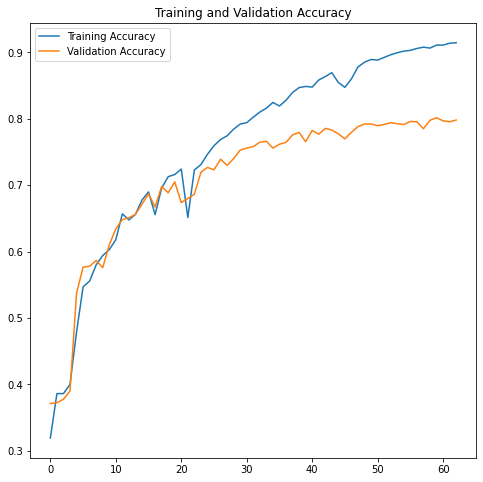

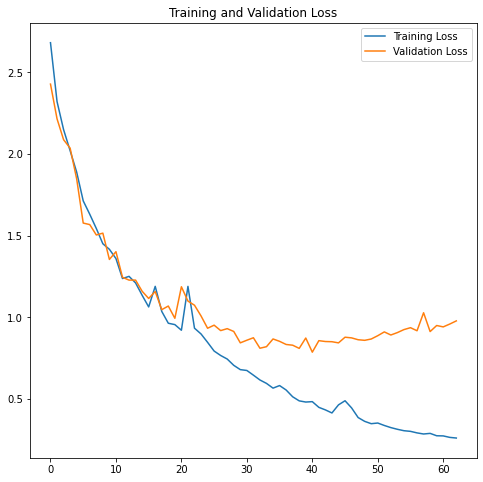

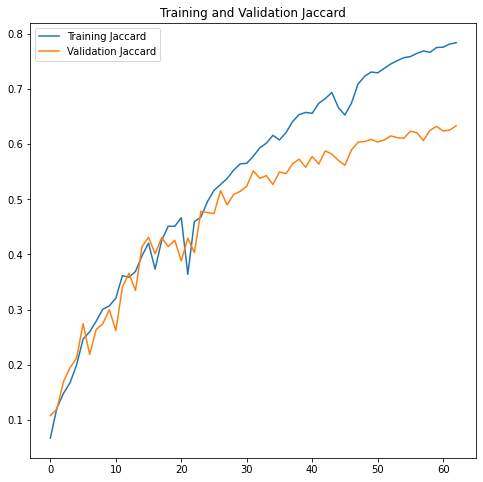

In [35]:
# Plot accuracy
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot jaccard index
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, training_jaccard, label='Training Jaccard')
plt.plot(epochs_range, validation_jaccard, label='Validation Jaccard')
plt.title('Training and Validation Jaccard')
plt.legend()
plt.show()

# **Load best model**

Here we can load the best model, if we use a custom metric (like jaccard index) we have to pass these metrics in **load_model(...)**.

In [25]:
dependencies = {'jaccard_index': jaccard_index}
model = keras.models.load_model('models/Unet_model.hdf5',custom_objects=dependencies)

2022-02-14 20:27:08.277999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 20:27:08.617318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 20:27:08.617810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 20:27:08.619342: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# **Evalute model on validation set**

Now we can use the model to make predictions on validation set.

In [36]:
validation_y_preds = model.predict(validation_x)
print('Prediction map shape: ', validation_y_preds.shape)
print('Prediction map type: ', validation_y_preds.dtype)

Prediction map shape:  (100, 320, 480, 23)
Prediction map type:  float32


Below cell evaluates model on validation set computing loss, accuracy and jaccard index.

In [37]:
model.evaluate(validation_x, validation_y)

4/4 [==============================] - 2s 240ms/step - loss: 0.9100 - acc: 0.7992 - jaccard_index: 0.6494


[0.9100473523139954, 0.7991719841957092, 0.6493850946426392]

Transform the values of class_weights into a numpy array.

In [38]:
numpy_class_weights = np.array(list(class_weights.values()))

Below cell multiplies each one-encoded array for class weight, in this way we can mody the weight for each class.

In [39]:
for img in range(validation_y.shape[0]):
    for h in range(validation_y[0].shape[0]):
        for w in range(validation_y[0].shape[1]):
            validation_y_preds[img, h, w] *= numpy_class_weights

Now we can compute the confusion matrix through *confusion_matrix of sklearn*.

Before this we have to convert *validation_y* and the *validation_y_preds* to a flatten array.

In [40]:
flat_validation_y = np.argmax(validation_y, axis=-1).flatten()
flat_validation_y_preds = np.argmax(validation_y_preds, axis=-1).flatten()

The cell below computes and plots the confusion matrix using seaborn library and heatmap. 

On columns there are real predicted, on rows real.

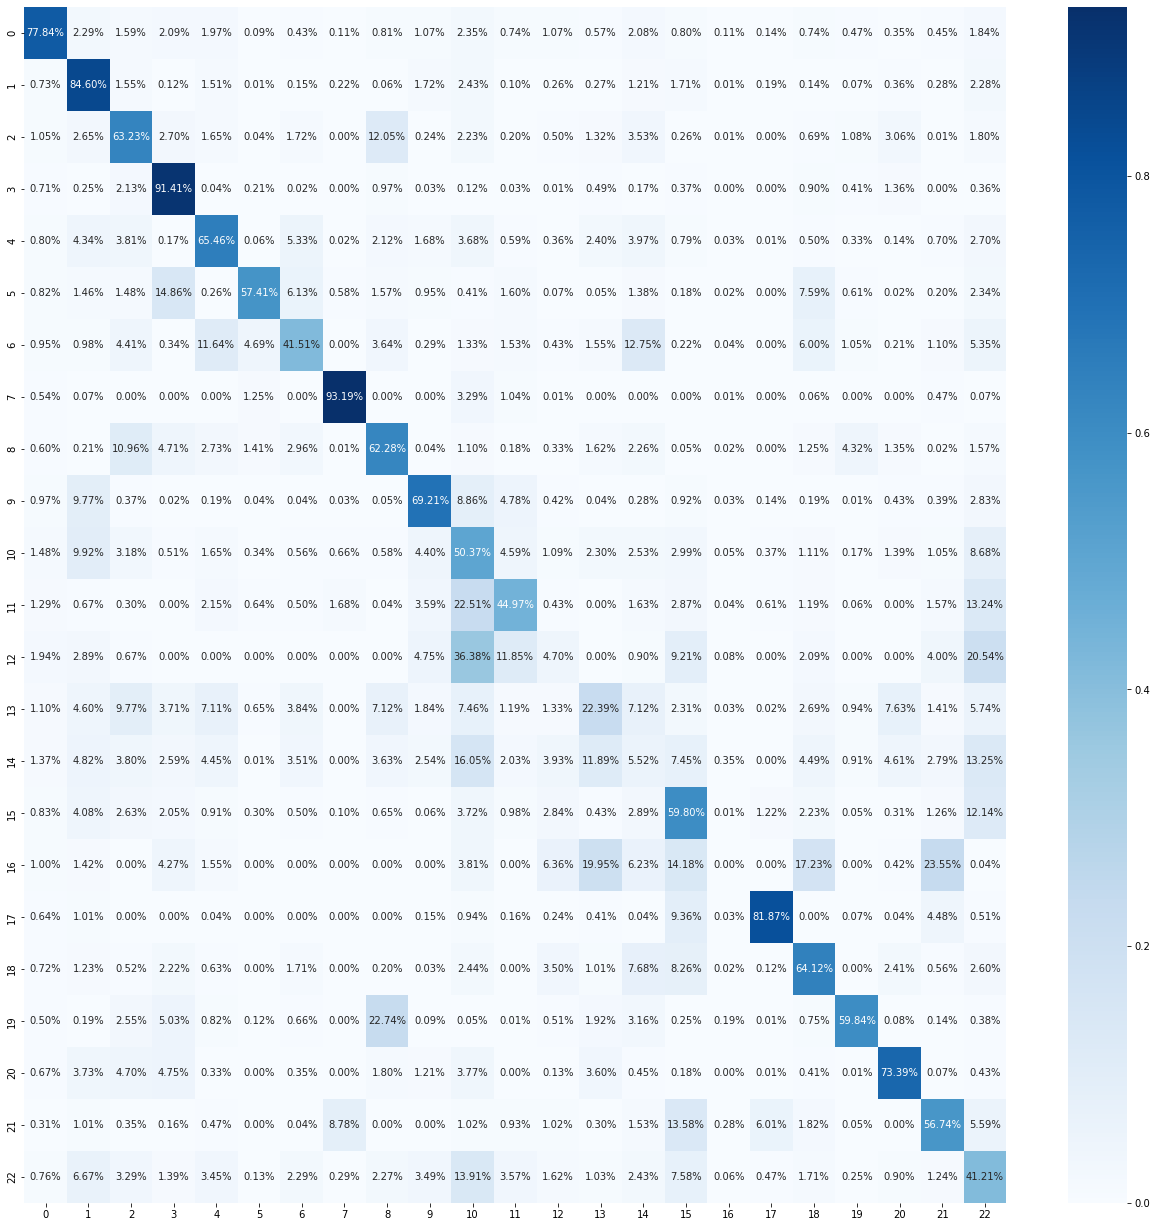

In [41]:
cm = confusion_matrix(flat_validation_y, flat_validation_y_preds, normalize='true') 

fig, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=ax);

And now we can compute Precision, Recall and F1-Score for each class for validation.

In [42]:
cr = classification_report(flat_validation_y, flat_validation_y_preds, output_dict=True)

pd.DataFrame(cr).T

precision    recall  f1-score       support
0              0.291784  0.778374  0.424455  6.262800e+04
1              0.944297  0.846046  0.892475  5.720312e+06
2              0.427534  0.632316  0.510141  4.800720e+05
3              0.947281  0.914054  0.930371  3.257105e+06
4              0.800690  0.654638  0.720336  1.132868e+06
5              0.833536  0.574096  0.679908  3.041650e+05
6              0.197377  0.415099  0.267540  9.287900e+04
7              0.794249  0.931923  0.857596  9.611200e+04
8              0.764666  0.622833  0.686500  1.138386e+06
9              0.806401  0.692123  0.744904  1.035139e+06
10             0.329553  0.503728  0.398437  4.247830e+05
11             0.220482  0.449726  0.295898  7.469000e+04
12             0.005142  0.047020  0.009270  6.125000e+03
13             0.194719  0.223929  0.208305  1.271920e+05
14             0.002097  0.055178  0.004040  8.971000e+03
15             0.301355  0.598004  0.400755  1.535190e+05
16             0.000000  0.000000  0.000000  2.391000e+03
17             0.798963  0.818723  0.808722  1.004760e+05
18             0.181653  0.641178  0.283100  4.114300e+04
19             0.665451  0.598442  0.630170  2.738580e+05
20             0.554586  0.733898  0.631765  2.119040e+05
21             0.205436  0.567393  0.301652  2.456500e+04
22             0.430639  0.412116  0.421174  5.907170e+05
accuracy       0.761264  0.761264  0.761264  7.612639e-01
macro avg      0.465126  0.552645  0.482935  1.536000e+07
weighted avg   0.816769  0.761264  0.782862  1.536000e+07

# **Create output map on validation set**

In this section we compute accuracy or jaccard (on choice) to visualize the best and worst results on validation set.

In [43]:
validation_y_preds_argmax = np.argmax(validation_y_preds, axis=-1)

In [44]:
validation_y_original = np.argmax(validation_y, axis=-1)

In [49]:
validation_metric = 'Jaccard'      # Accuracy or Jaccard
validation_image_to_show = 15 # Number of results to show

validation_scores=[]

for i in range(validation_y_preds_argmax.shape[0]):
    if (validation_metric == 'Accuracy'):
      score = sklearn.metrics.accuracy_score(validation_y_original[i].ravel(), validation_y_preds_argmax[i].ravel())
    elif (validation_metric == 'Jaccard'):
        score = sklearn.metrics.jaccard_score(validation_y_original[i].ravel(), validation_y_preds_argmax[i].ravel(), average="micro")
    validation_scores.append((i,score))

Mean of jaccard or accuracy.

In [50]:
sum([score[1] for score in validation_scores]) / len(validation_scores)

0.6306818069030533

# **Show best results on validation set**

Executing the cell below we can see the best prediction maps obtained from the model.

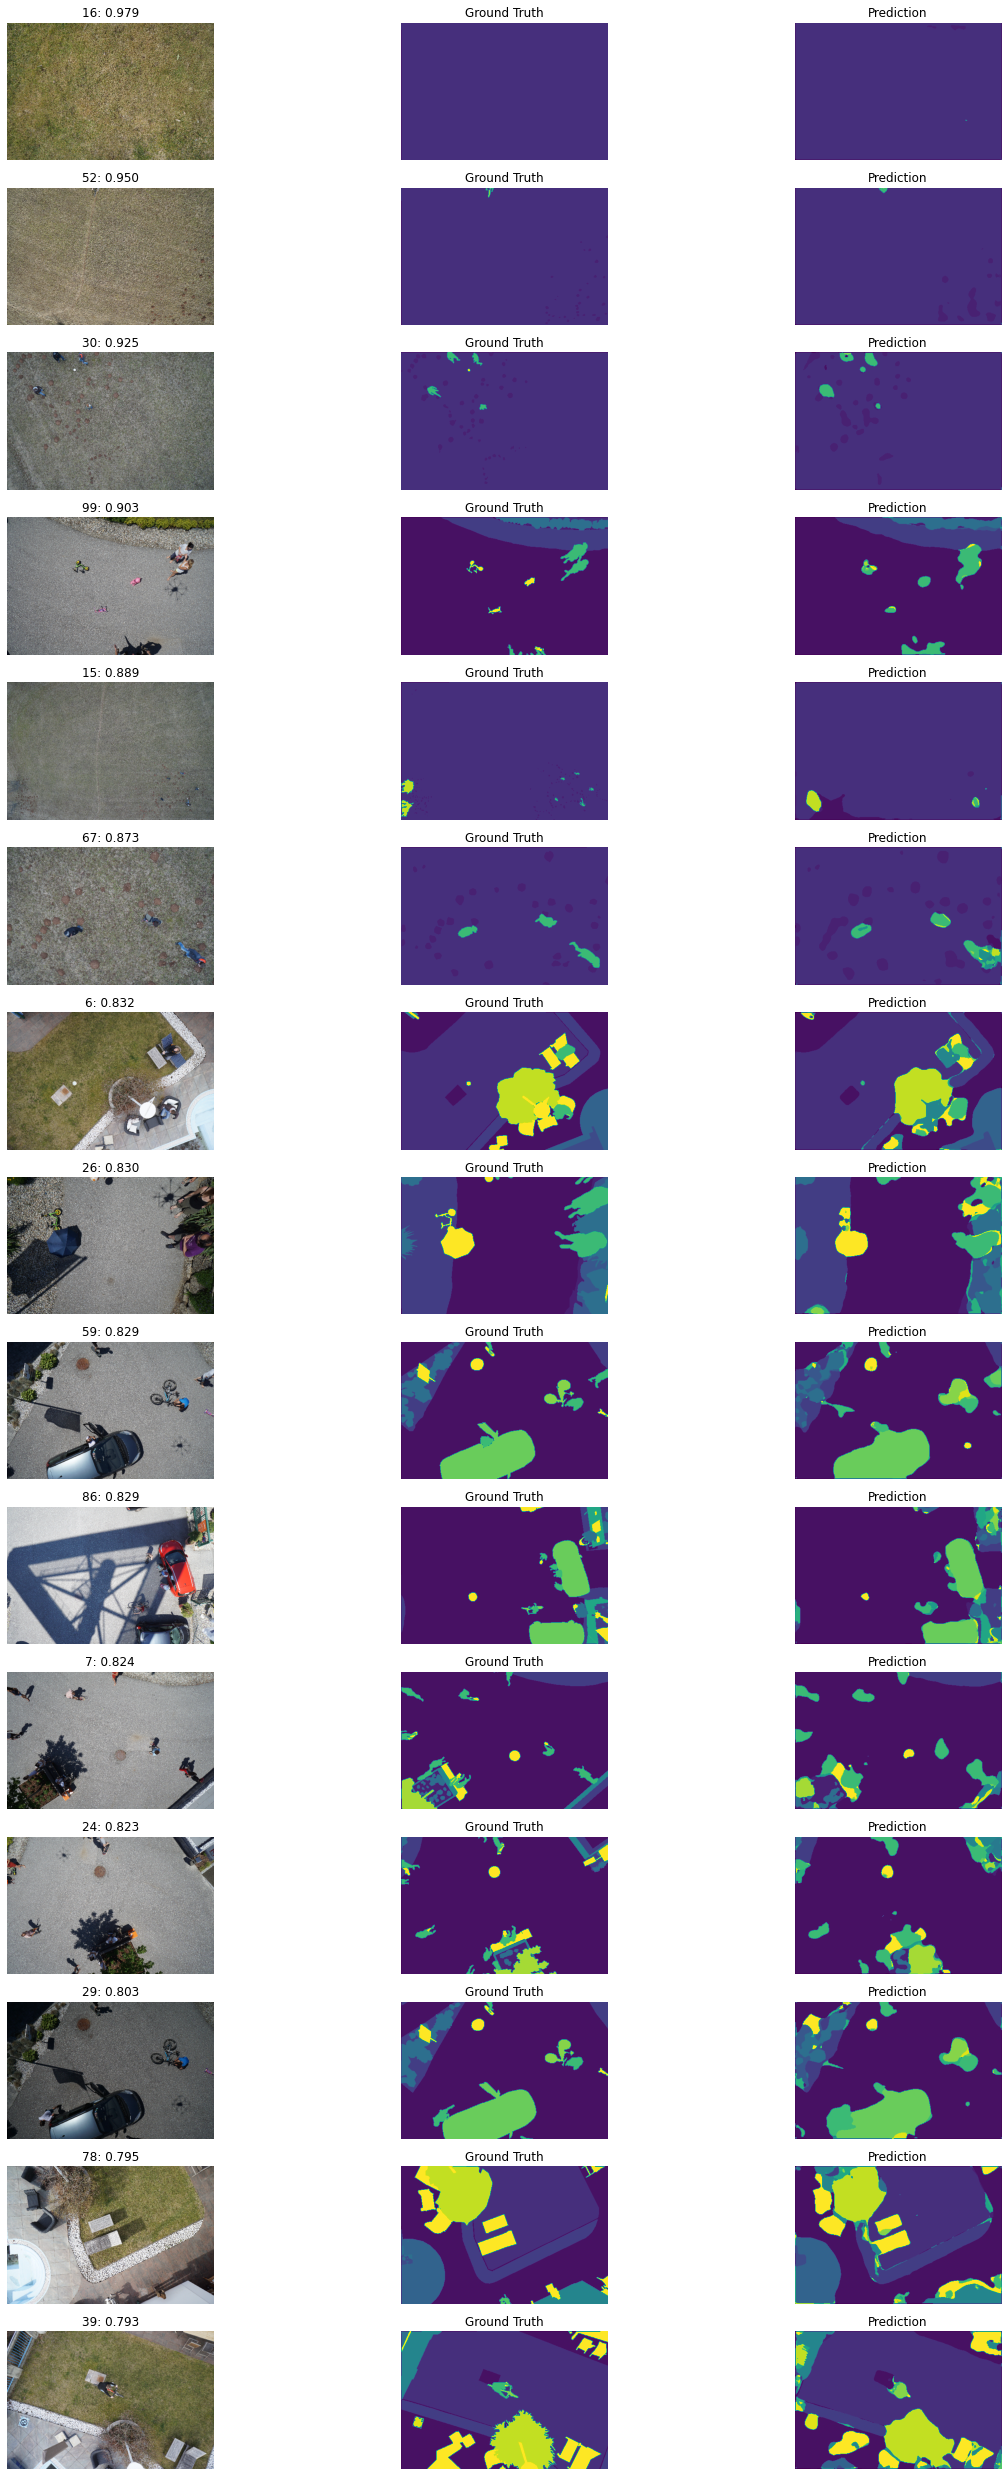

In [51]:
validation_scores.sort(key=lambda elem: elem[1], reverse=True)
    
_, axs = plt.subplots(validation_image_to_show, 3,figsize=(20, 3 * validation_image_to_show))

for i in range(validation_image_to_show):
  image_idx = validation_scores[i][0]
  axs[i, 0].imshow(validation_x[image_idx]) 
  axs[i, 0].axis('off')
  axs[i, 0].set_title('%d: %.3f'%(image_idx,validation_scores[i][1]))
    
  axs[i, 1].imshow(validation_y_original[image_idx], vmin=0, vmax=22) # vmin and vmax are used to indicate the min value and max value of the class
  axs[i, 1].axis('off')
  axs[i, 1].set_title('Ground Truth')

  axs[i, 2].imshow(validation_y_preds_argmax[image_idx], vmin=0, vmax=22)
  axs[i, 2].axis('off')
  axs[i, 2].set_title('Prediction')

# **Show worst results validation set**

In the opposite way executing the cell below we can see the worst prediction maps obtained from the model so that we can observe where the model miss.

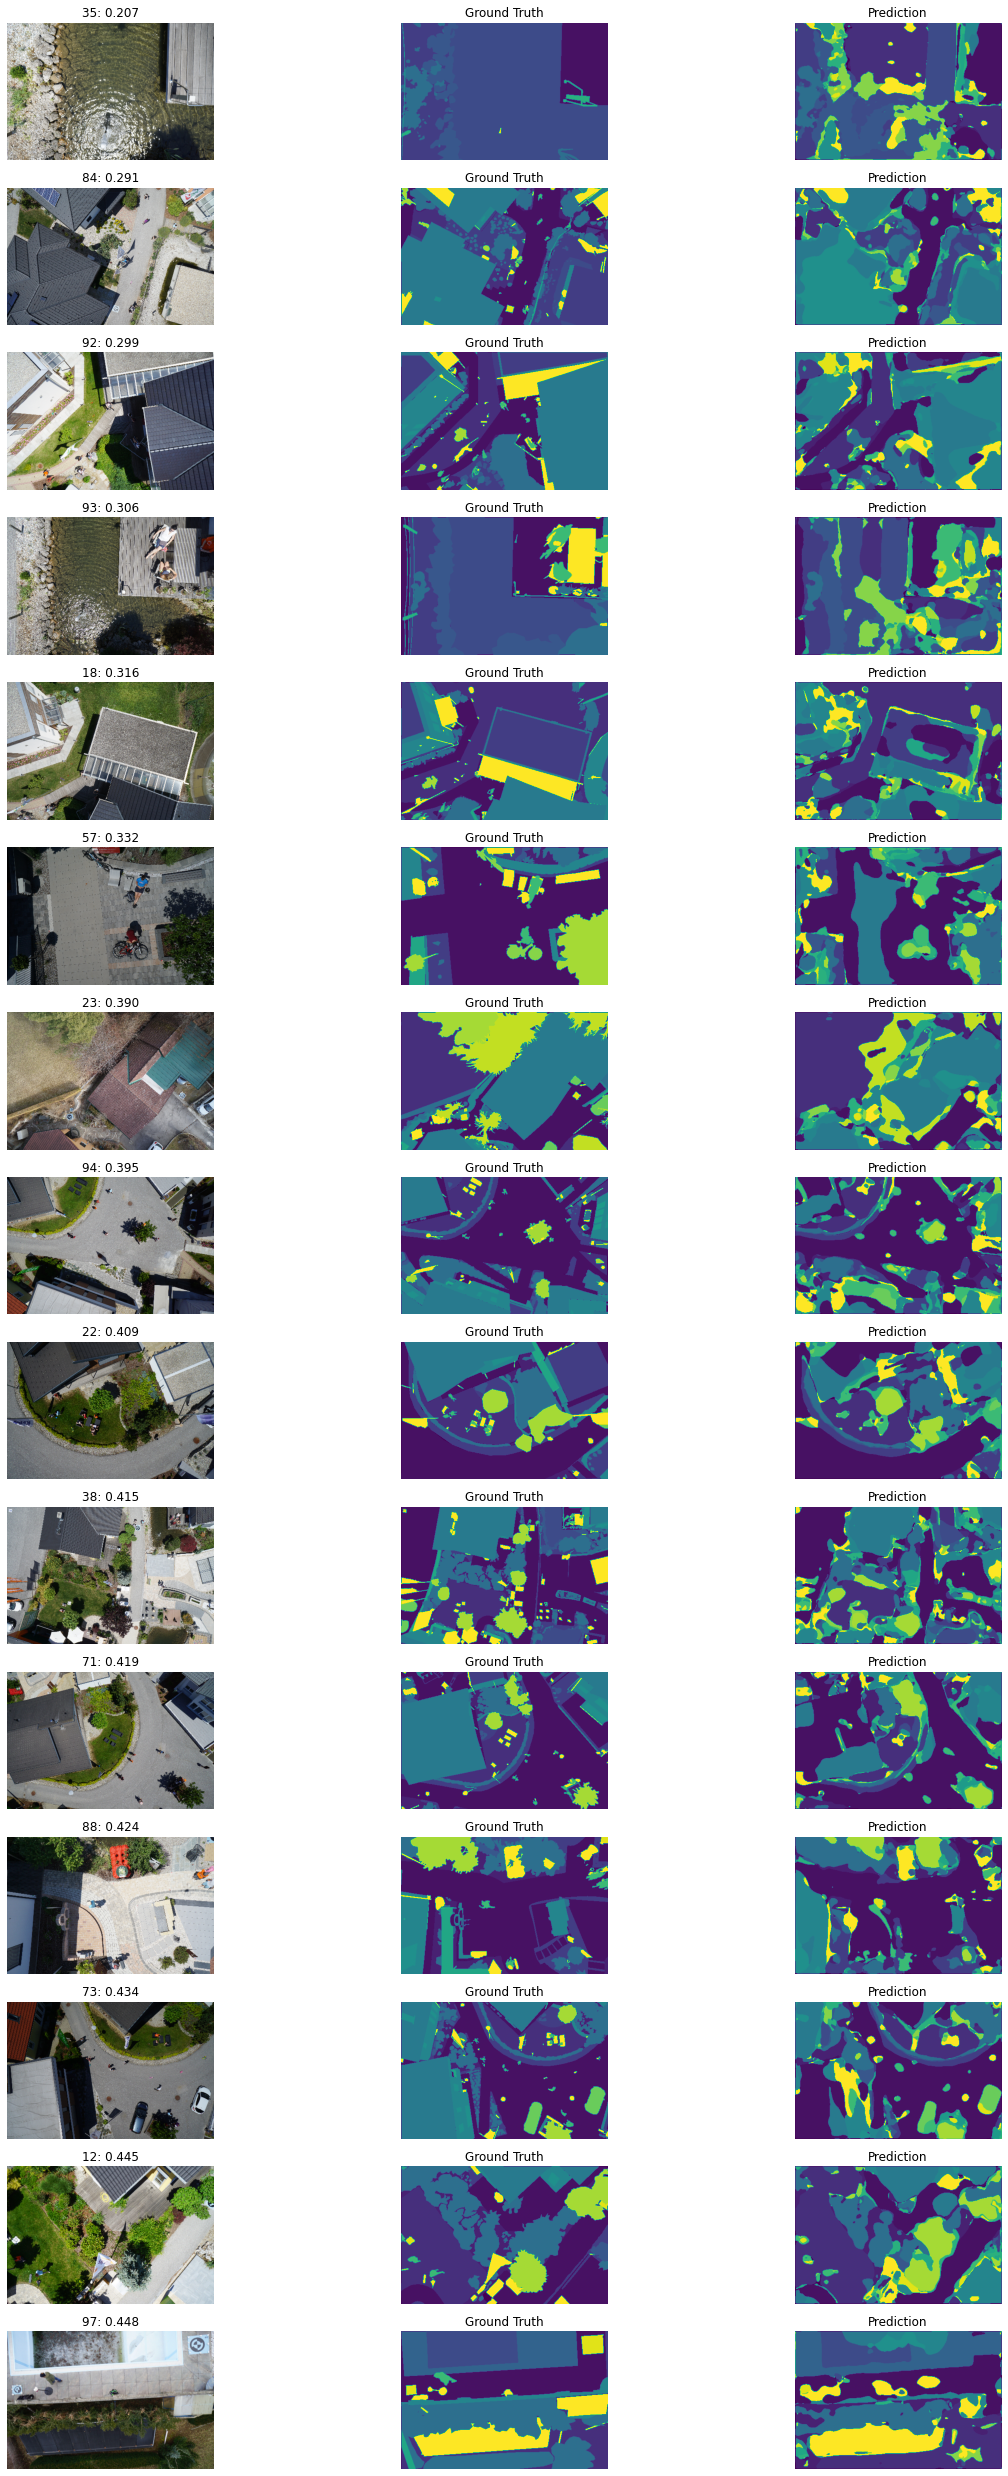

In [52]:
validation_scores.sort(key=lambda elem: elem[1])    
    
_, axs = plt.subplots(validation_image_to_show, 3,figsize=(20, 3 * validation_image_to_show))

for i in range(validation_image_to_show):
  image_idx = validation_scores[i][0]
  axs[i, 0].imshow(validation_x[image_idx]) 
  axs[i, 0].axis('off')
  axs[i, 0].set_title('%d: %.3f'%(image_idx,validation_scores[i][1]))
    
  axs[i, 1].imshow(validation_y_original[image_idx], vmin=0, vmax=22)
  axs[i, 1].axis('off')
  axs[i, 1].set_title('Ground Truth')

  axs[i, 2].imshow(validation_y_preds_argmax[image_idx], vmin=0, vmax=22)
  axs[i, 2].axis('off')
  axs[i, 2].set_title('Prediction')

# **Evalute model on test set**

Finally we can try the model on test set.

In [53]:
test_y_preds = model.predict(test_x)
print('Prediction map shape: ', test_y_preds.shape)
print('Prediction map type: ', test_y_preds.dtype)

Prediction map shape:  (100, 320, 480, 23)
Prediction map type:  float32


Below cell evaluates model on test set computing loss, accuracy and jaccard index.

In [54]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 1s 244ms/step - loss: 0.8058 - acc: 0.8144 - jaccard_index: 0.6636


[0.805798351764679, 0.8144134283065796, 0.6636224985122681]

Like before for weights.

In [55]:
numpy_class_weights = np.array(list(class_weights.values()))

In [56]:
for img in range(test_y.shape[0]):
    for h in range(test_y[0].shape[0]):
        for w in range(test_y[0].shape[1]):
            test_y_preds[img, h, w] *= numpy_class_weights

Now we can see confusion matrix like before.

In [57]:
flat_test_y = np.argmax(test_y, axis=-1).flatten()
flat_test_y_preds = np.argmax(test_y_preds, axis=-1).flatten()

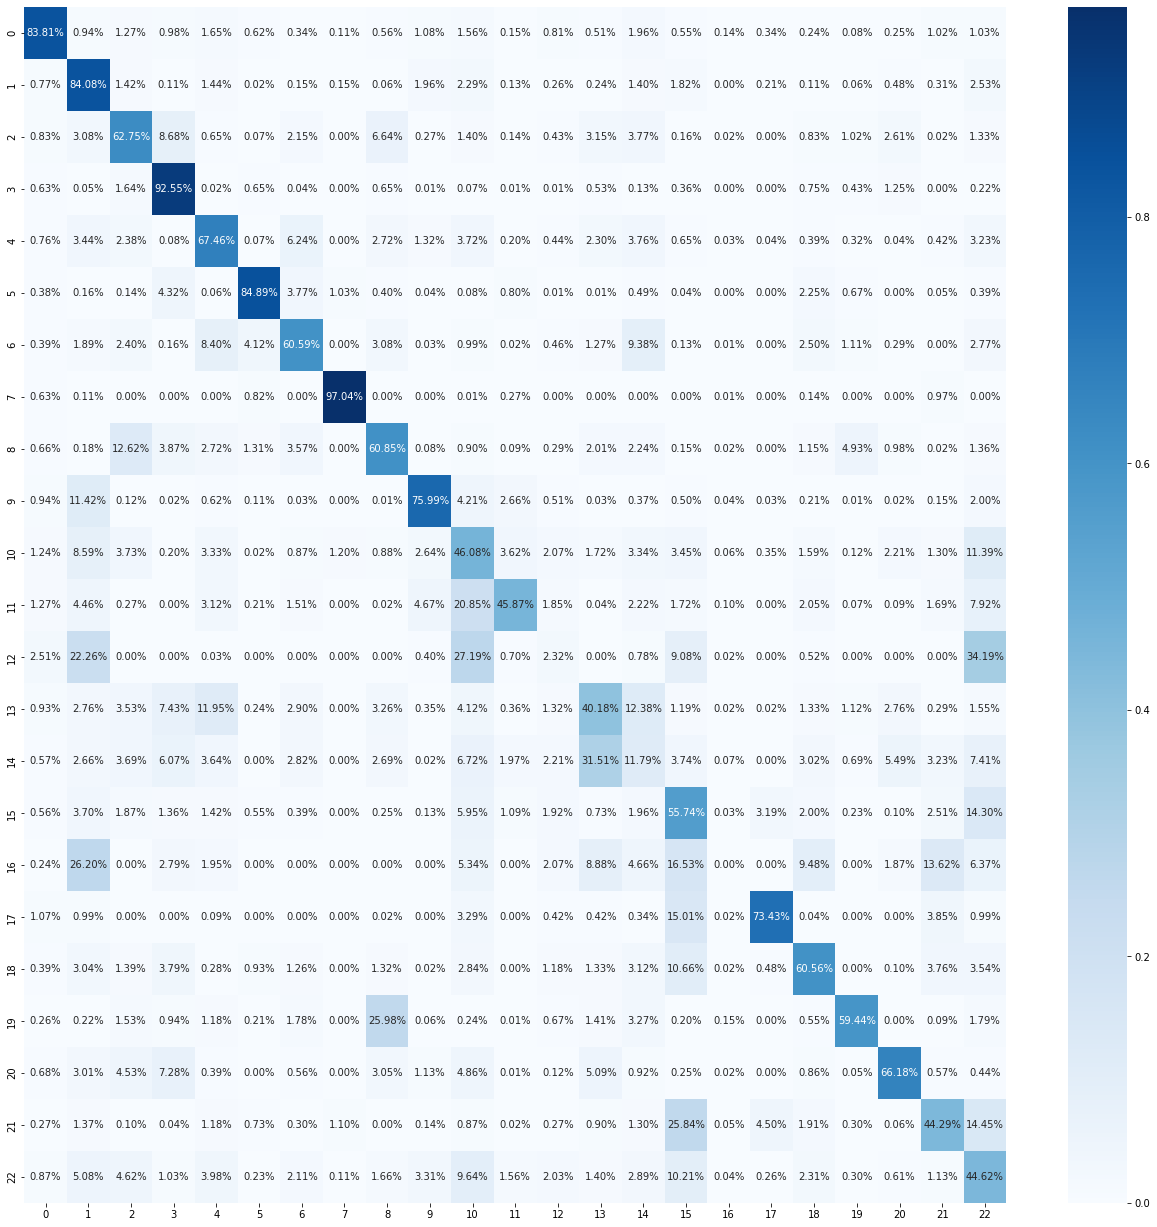

In [58]:
cm = confusion_matrix(flat_test_y, flat_test_y_preds, normalize='true') 

fig, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=ax);

In [59]:
cr = classification_report(flat_test_y, flat_test_y_preds, output_dict=True)

pd.DataFrame(cr).T

precision    recall  f1-score       support
0              0.317551  0.838133  0.460593  6.271200e+04
1              0.941224  0.840812  0.888189  5.539118e+06
2              0.491448  0.627493  0.551200  5.420570e+05
3              0.952761  0.925515  0.938940  3.242394e+06
4              0.803503  0.674557  0.733405  1.157968e+06
5              0.880203  0.848878  0.864257  4.137590e+05
6              0.277991  0.605918  0.381124  1.099010e+05
7              0.829736  0.970383  0.894565  8.846200e+04
8              0.765629  0.608513  0.678089  1.038163e+06
9              0.863337  0.759923  0.808336  1.315900e+06
10             0.313107  0.460843  0.372875  3.360150e+05
11             0.301721  0.458653  0.363993  6.826300e+04
12             0.002232  0.023167  0.004072  5.741000e+03
13             0.352007  0.401797  0.375257  1.705090e+05
14             0.002858  0.117888  0.005581  6.099000e+03
15             0.292157  0.557438  0.383382  1.671380e+05
16             0.000000  0.000000  0.000000  2.511000e+03
17             0.785185  0.734312  0.758897  1.108780e+05
18             0.124726  0.605586  0.206850  2.220000e+04
19             0.661207  0.594358  0.626003  2.839300e+05
20             0.478522  0.661834  0.555445  1.500240e+05
21             0.274120  0.442856  0.338632  4.134300e+04
22             0.400306  0.446198  0.422008  4.849150e+05
accuracy       0.775632  0.775632  0.775632  7.756323e-01
macro avg      0.483110  0.574133  0.504856  1.536000e+07
weighted avg   0.827348  0.775632  0.796491  1.536000e+07

# **Create output map on test set**

In this section we do like before but this time on test set.

In [60]:
test_y_preds_argmax = np.argmax(test_y_preds, axis=-1)

In [61]:
test_y_original = np.argmax(test_y, axis=-1)

In [66]:
test_metric = 'Jaccard'      # Accuracy or Jaccard
test_image_to_show = 15 # Number of results to show

test_scores=[]

for i in range(test_y_preds_argmax.shape[0]):
    if (validation_metric == 'Accuracy'):
      score = sklearn.metrics.accuracy_score(test_y_original[i].ravel(), test_y_preds_argmax[i].ravel())
    elif (validation_metric == 'Jaccard'):
        score = sklearn.metrics.jaccard_score(test_y_original[i].ravel(), test_y_preds_argmax[i].ravel(), average="micro")
    test_scores.append((i,score))

In [67]:
sum([score[1] for score in test_scores]) / len(test_scores)

0.6464626413822638

# **Show best results on test set**

Like before to see best results on test set.

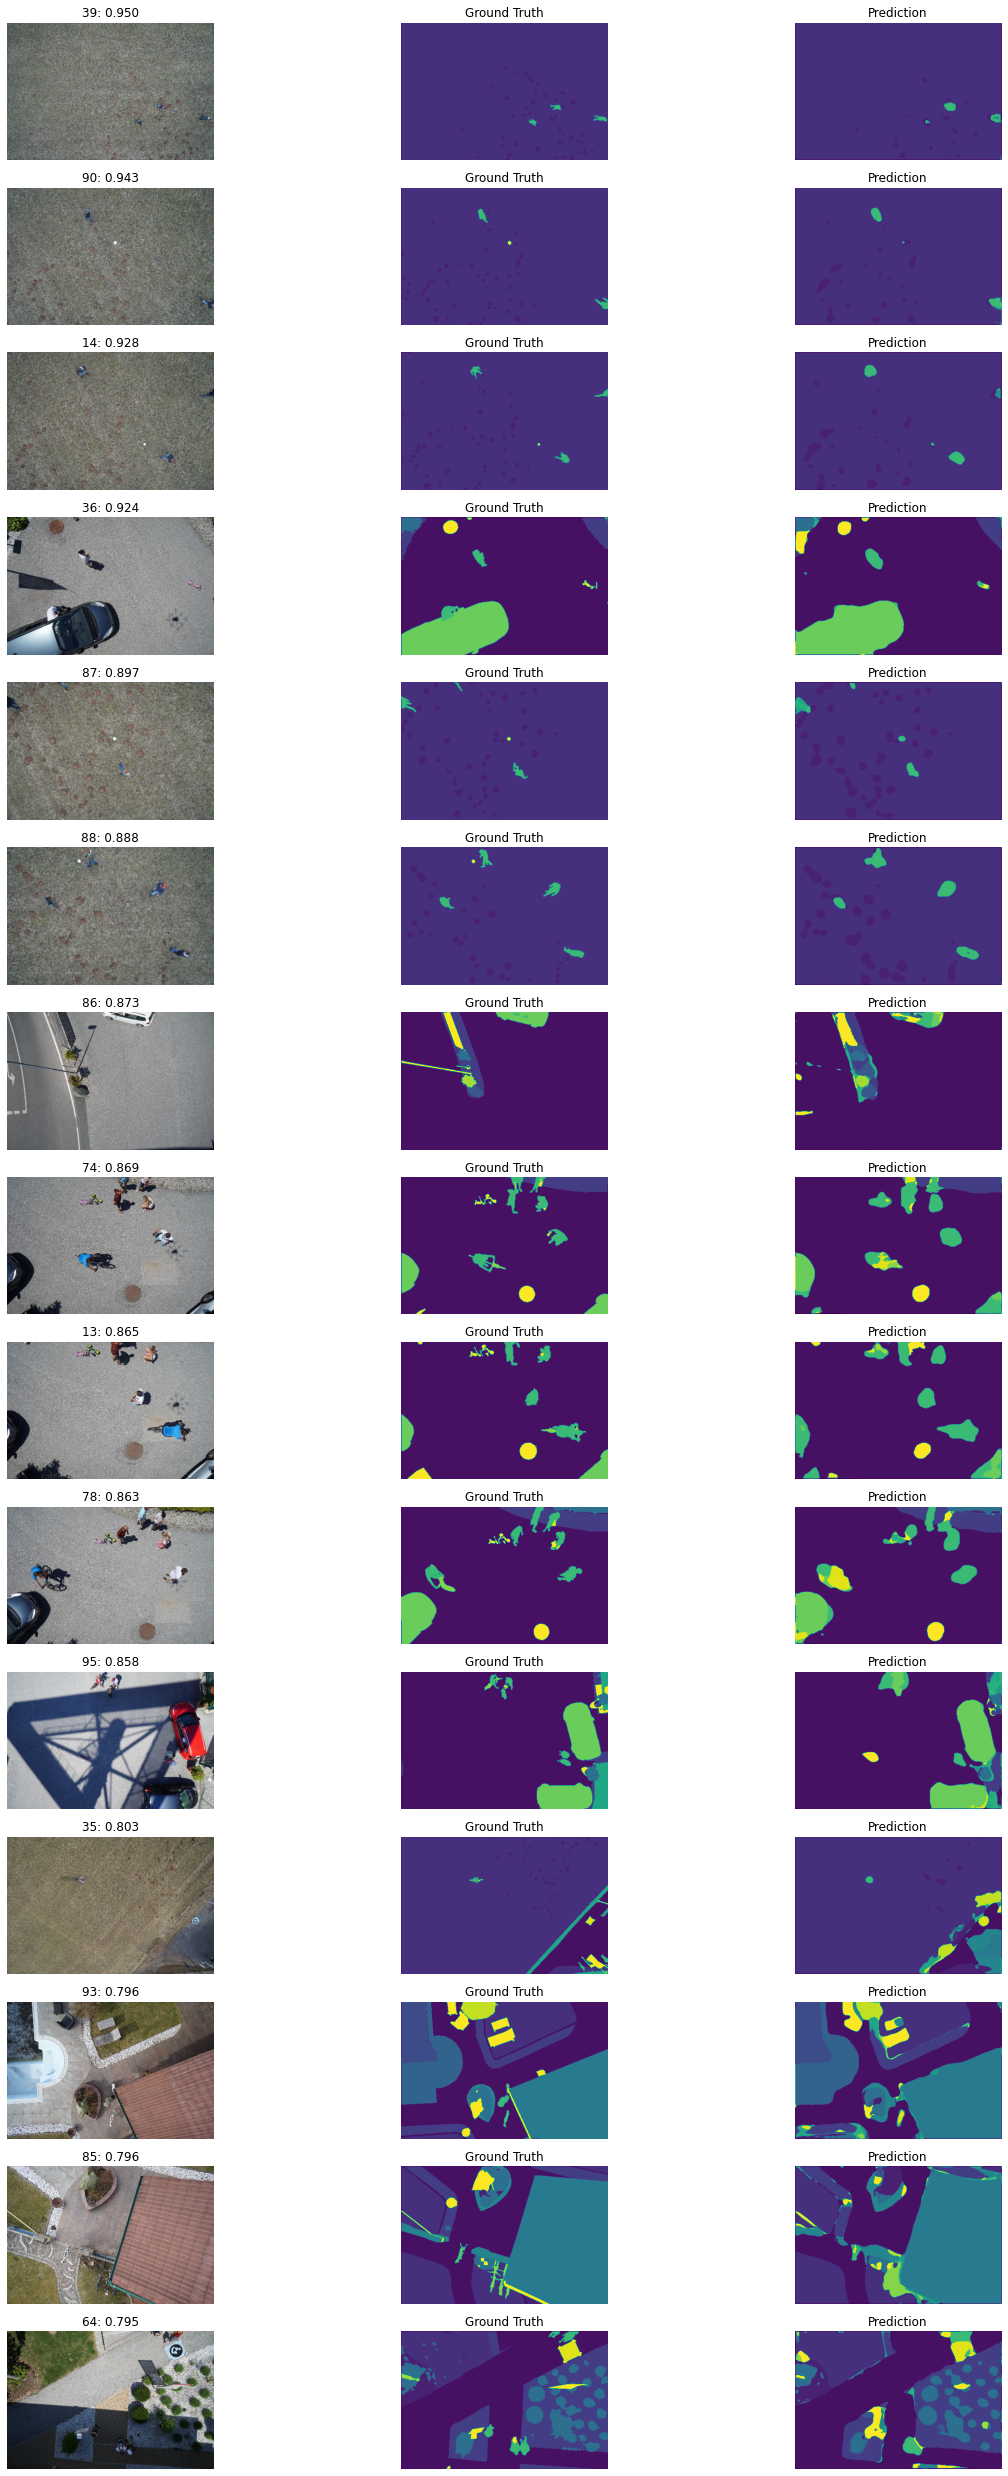

In [80]:
test_scores.sort(key=lambda elem: elem[1], reverse=True)
    
_, axs = plt.subplots(test_image_to_show, 3,figsize=(20, 3 * test_image_to_show))

for i in range(test_image_to_show):
  image_idx = test_scores[i][0]
  axs[i, 0].imshow(test_x[image_idx]) 
  axs[i, 0].axis('off')
  axs[i, 0].set_title('%d: %.3f'%(image_idx, test_scores[i][1]))
    
  axs[i, 1].imshow(test_y_original[image_idx], vmin=0, vmax=22)
  axs[i, 1].axis('off')
  axs[i, 1].set_title('Ground Truth')

  axs[i, 2].imshow(test_y_preds_argmax[image_idx], vmin=0, vmax=22)
  axs[i, 2].axis('off')
  axs[i, 2].set_title('Prediction')

# **Show worst results on test set**

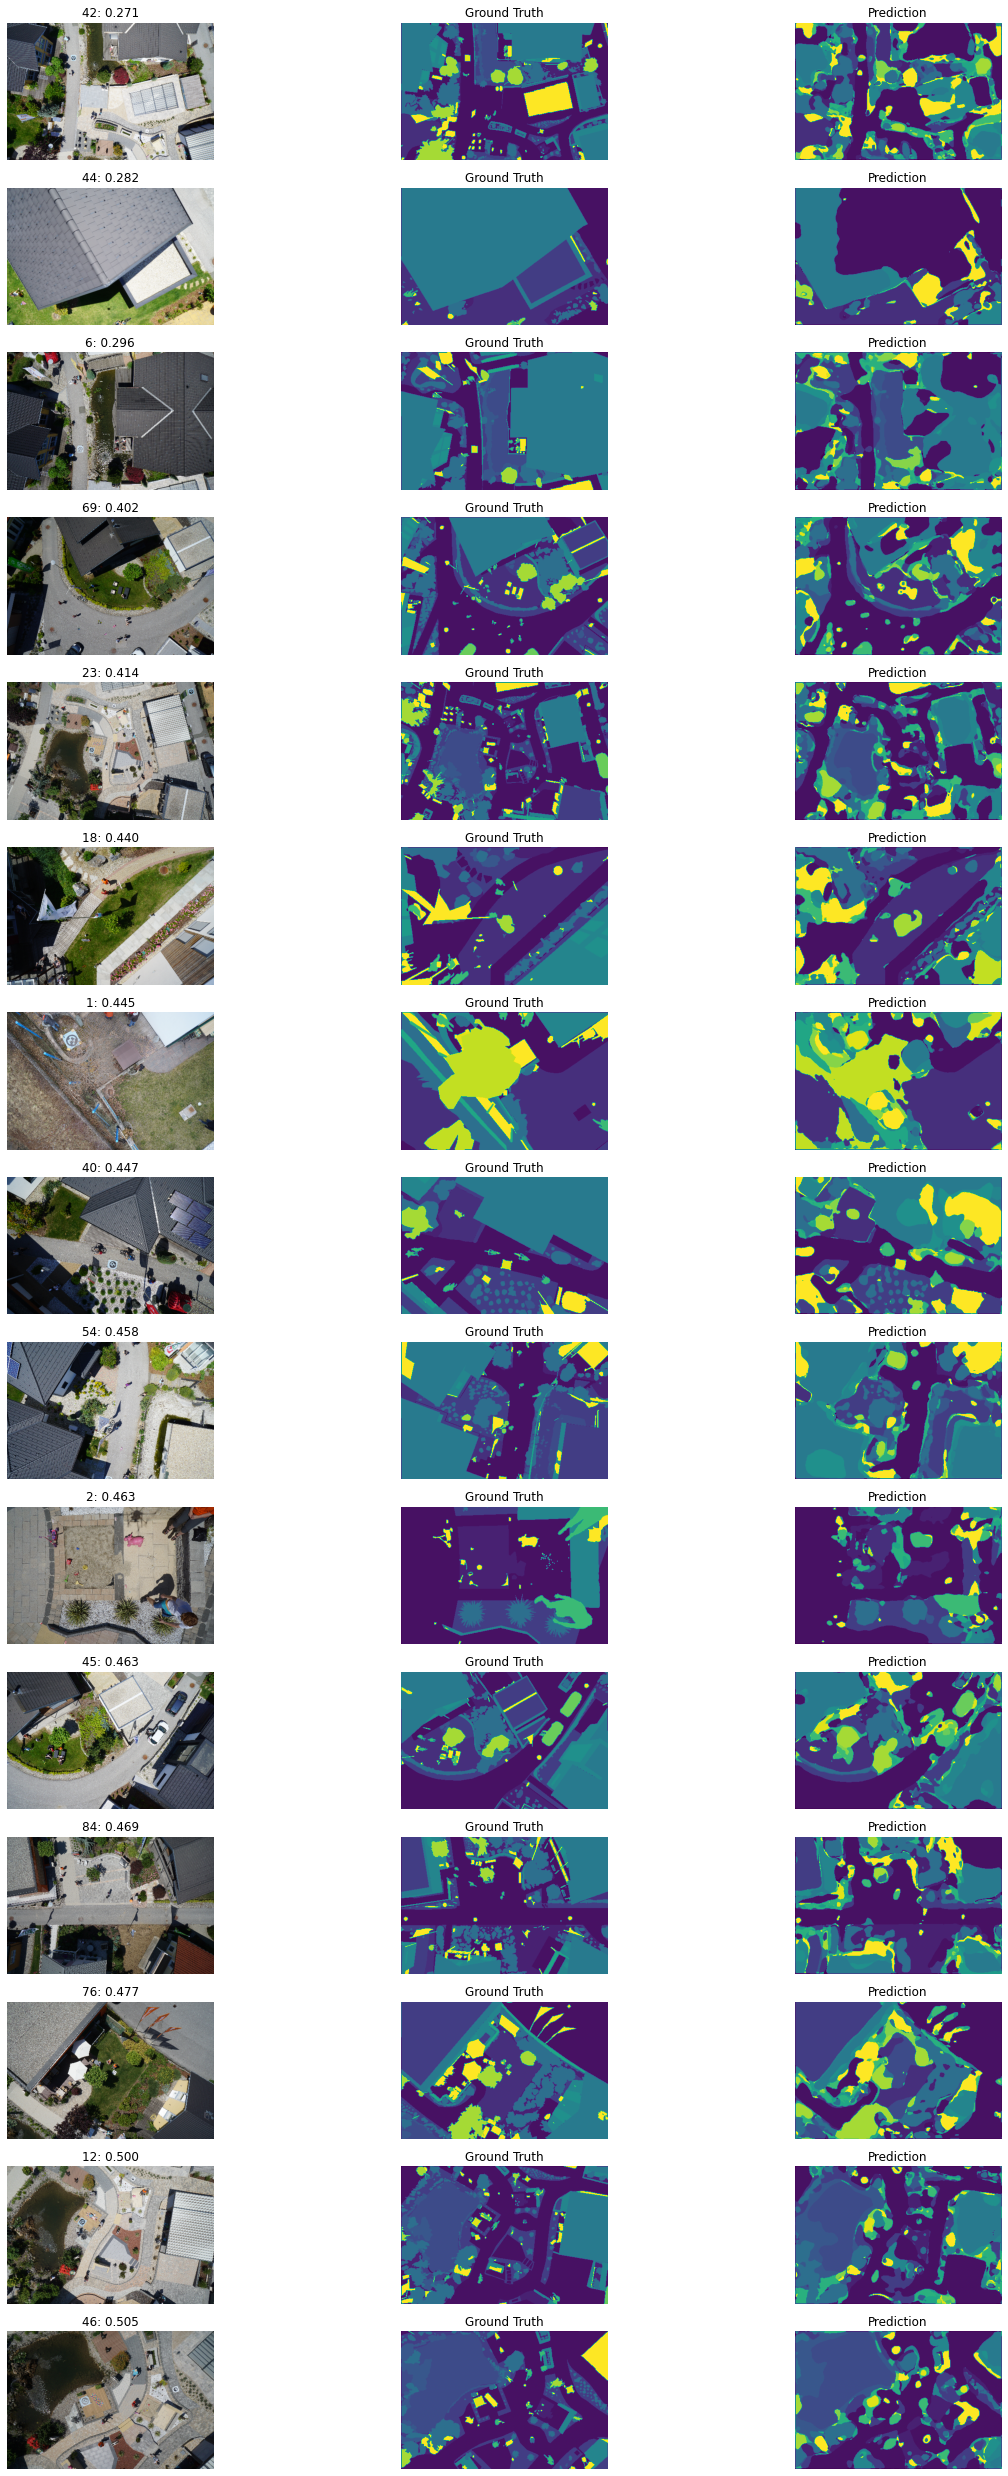

In [81]:
test_scores.sort(key=lambda elem: elem[1])    
    
_, axs = plt.subplots(test_image_to_show, 3,figsize=(20, 3 * test_image_to_show))

for i in range(test_image_to_show):
  image_idx = test_scores[i][0]
  axs[i, 0].imshow(test_x[image_idx]) 
  axs[i, 0].axis('off')
  axs[i, 0].set_title('%d: %.3f'%(image_idx, test_scores[i][1]))
    
  axs[i, 1].imshow(test_y_original[image_idx], vmin=0, vmax=22)
  axs[i, 1].axis('off')
  axs[i, 1].set_title('Ground Truth')

  axs[i, 2].imshow(test_y_preds_argmax[image_idx], vmin=0, vmax=22)
  axs[i, 2].axis('off')
  axs[i, 2].set_title('Prediction')